In [37]:
import tensorflow as tf
from tensorflow import keras
from keras import backend
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, BatchNormalization
import imageio
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import pandas as pd
from scipy.stats import norm
import math

In [2]:
checkpoint_path_model1 = '../../../data/models/20201030_filtered_gaussian/'
val_files = ['../../../data/commaai/test_files/val_file_filtered/val.tfrecords']

In [3]:
# build model
Input = tf.keras.layers.Input(shape=(66, 200, 3,), name='image')
x = Conv2D(24, kernel_size=(5, 5), activation='relu', strides=(2, 2))(Input)
x = BatchNormalization()(x)
x = Conv2D(36, kernel_size=(5, 5), activation='relu', strides=(2, 2))(x)
x = BatchNormalization()(x)
x = Conv2D(48, kernel_size=(5, 5), activation='relu', strides=(2, 2))(x)
x = BatchNormalization()(x)
x = Conv2D(64, kernel_size=(3, 3), activation='relu')(x)
x = BatchNormalization()(x)
x = Conv2D(64, kernel_size=(3, 3), activation='relu')(x)
x = Flatten()(x)
x = Dense(1164)(x)
x = Dropout(0.5)(x)
x = Dense(100)(x)
x = Dropout(0.2)(x)
x = Dense(50)(x) 
x = Dense(10)(x)
Output = Dense(1, name = 'output_layer')(x)

model_1 = tf.keras.models.Model(
      inputs = [Input], outputs = [Output])

def rmse(y_true, y_pred):
	return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1))

model_1.load_weights(tf.train.latest_checkpoint(checkpoint_path_model1))


model_1.compile(
    loss = 'mae',
    optimizer = keras.optimizers.Adadelta(learning_rate = 0.0005, rho = 0.95, epsilon = 1e-07, name = 'Adadelta'),
    metrics=['mse', 'mae'])

model_1_est = tf.keras.estimator.model_to_estimator(
keras_model = model_1, model_dir = checkpoint_path_model1)


Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.core.Dense object at 0x7fc11c66ff40> and <tensorflow.python.keras.layers.core.Dropout object at 0x7fc11c6753a0>).

Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.core.Dense object at 0x7fc11c6059d0> and <tensorflow.python.keras.layers.core.Dropout object at 0x7fc11c605f40>).

Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.core.Dense object at 0x7fc11c618d30> and <tensorflow.python.keras.layers.core.Dense object at 0x7fc11c618ee0>).
INFO:tensorflow:Using default config.
INFO:tensorflow:Using the Keras model provided.
INFO:tensorflow:Using config: {'_model_dir': '../../../data/models/20201030_filtered_gaussian/', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta

In [4]:
def _parse_function_val(proto):
    # define your tfrecord again. Remember that you saved your image as a string.
    keys_to_features = {'image': tf.io.FixedLenFeature([], tf.string),
                        'label': tf.io.FixedLenFeature([], tf.float32),
                        'rows': tf.io.FixedLenFeature([], tf.int64),
                        'cols': tf.io.FixedLenFeature([], tf.int64),
                        'depth': tf.io.FixedLenFeature([], tf.int64),
                        'tr_label': tf.io.FixedLenFeature([], tf.float32)
                       }

    # Load one example
    parsed_example = tf.io.parse_single_example(proto, keys_to_features)

    image_shape = tf.stack([66, 200, 3])
    image_raw = parsed_example['image']

    label = tf.cast(parsed_example['label'], tf.float32)
    tr_label = tf.cast(parsed_example['tr_label'], tf.float32)
    image = tf.io.decode_raw(image_raw, tf.uint8)
    image = tf.cast(image, tf.float32)

    image = tf.reshape(image, image_shape)/255 

    return {'image':image}, tr_label, label 

def imgs_input_fn_val(filenames, perform_shuffle = False, repeat_count = 1, batch_size = 10472): 
    
    # reads in single training example and returns it in a format that the estimator can
    # use
    
    dataset = tf.data.TFRecordDataset(filenames = filenames)
    dataset = dataset.map(_parse_function_val)
    dataset = dataset.repeat(repeat_count)  # Repeats dataset this # times
    dataset = dataset.batch(batch_size)  # Batch size to use
    iterator = tf.compat.v1.data.make_one_shot_iterator(dataset)
    batch_features, batch_labels_tr, batch_labels = iterator.get_next()
    
    return batch_features, batch_labels_tr, batch_labels

In [5]:
images = []
labels = []
for i in range(0,1):
    image, tr_label, label = imgs_input_fn_val(val_files)
    images.append(image)
    labels.append(label)
labels = np.array(labels)

In [6]:
pred = model_1.predict(image['image'])

In [7]:
pred = pred.reshape(10472)

In [29]:
df_pred = pd.DataFrame(data = {'pred': pred, 'true_label': labels})

In [9]:
def find_closest_element(y: float, arr: np.ndarray):
    index = np.searchsorted(arr,y)

    if (index >= 1) & (index < arr.shape[0]):
        res = [arr[index - 1], arr[index]]
    elif (index < arr.shape[0]):
        return np.array(index)
    else:
        return np.array(index - 1)

    if res[0] == res[1]:
        return np.array(index - 1)
    else:
        diff_pre = np.abs(y-res[0])
        diff_aft = np.abs(y-res[1])
        if diff_pre == diff_aft:
            return np.array(index - 1), 
        else:
            return index - 1 if diff_pre < diff_aft else index

In [11]:
density = pd.read_csv('../../../data/commaai/density/gaussian_density_filtered.csv')

In [30]:
df_pred['pred_retrans'] = df_pred['pred'].apply(lambda x: density.loc[find_closest_element(norm.cdf(x),density['cdf']), 'axes'])

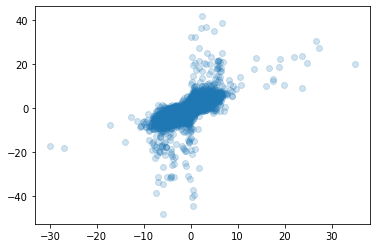

In [32]:
plt.scatter(df_pred['pred_retrans'], df_pred['true_label'], alpha = 0.2)

In [28]:
labels = labels.reshape(10472,)
np.mean(abs(pred_retrans - labels))

1.418524638173198

In [34]:
mse = np.mean(abs(pred_retrans - labels)**2)
mse

7.531830263758016

In [40]:
from sklearn.metrics import mean_squared_error
from math import sqrt

rms = sqrt(mean_squared_error(pred_retrans, labels))

In [41]:
rms

2.744418019135936

In [42]:
# accuracy 
np.mean(abs(pred_retrans - labels) < 6)

0.9799465240641712